# Continuous Normalizing Flow with OT-Flow

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/EmoryMLIP/DeepGenerativeModelingIntro/blob/main/examples/OTFlow.ipynb)


## Some References
- Original work on CNF by [Grathwohl et al. (2018)](https://arxiv.org/abs/1810.01367v3)
- The formulation here used optimal transport regularization and is described in [Onken, Wu Fung, Li, Ruthotto (2021)](https://arxiv.org/abs/2006.00104)
- Section 3.2 of our paper  [Introduction to Deep Generative Modeling](https://arxiv.org/abs/2103.05180)

## Short Mathematical Description

We train the generator by minimizing the negative log-likelihood of the samples:

\begin{equation}
    \newcommand{\bftheta}{\boldsymbol{\theta}}
    \newcommand{\bfx}{\mathbf{x}}
    \newcommand{\bfz}{\mathbf{z}}
    \newcommand{\bfy}{\mathbf{y}}
\min_{\bftheta}  \frac{1}{s} \sum_{i=1}^s \left( {\frac{1}{2}}\left\| g_{\bftheta}^{-1}\left(\bfx^{(i)}\right)\right\|^2 - \log\det\nabla  g_{\bftheta}^{-1}\left(\bfx^{(i)}\right) \right),
\end{equation}
where $\bfx^{(1)}, \ldots$ are sampled i.i.d. from the data distribution. Here, the idea is to use a generator given by the neural ODE

\begin{equation*}
	\partial_t \bfy(t) = v_{\bftheta}(\bfy(t),t), \quad \text{ where } \quad \bfy(0) = \bfz.
\end{equation*}

to obtain a tractable inverse and log-determinant. Since we penalize the transport costs, we obtain a dynamics with linear characteristics.
Also, we can write the velocity as the gradient of a value function.  This is described in detail in https://arxiv.org/abs/2006.00104.


In [1]:
# install requirements  (Colab only)
import sys,os
if 'google.colab' in sys.modules:
    dgm_dir = '/content/DeepGenerativeModelingIntro/'

    if not os.path.exists(dgm_dir):
        !git clone git://github.com/EmoryMLIP/DeepGenerativeModelingIntro.git
    sys.path.append(os.path.dirname(dgm_dir))

In [2]:
import torch
from torch import nn
import numpy as np
from torch import distributions
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 16, "text.usetex": False})
plt.rcParams.update({'image.interpolation' : None})
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 200

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Some suggested experiments

1. reduce the widths of the moon shapes so that the intrinsic dimensionality reduces to one
1. try the other dataset or create your own more challenging distribution
1. vary the hyperparameters (learning rate, number of layers, width, ...) and see how the performance changes
1. (for later as this takes more time) use a different layer with tractable inverse and log-determinant

## Setup the Dataset and Plotting

Text(0.5, 1.0, 'dataset: moons $\\mathbf{x}^{(i)}$')

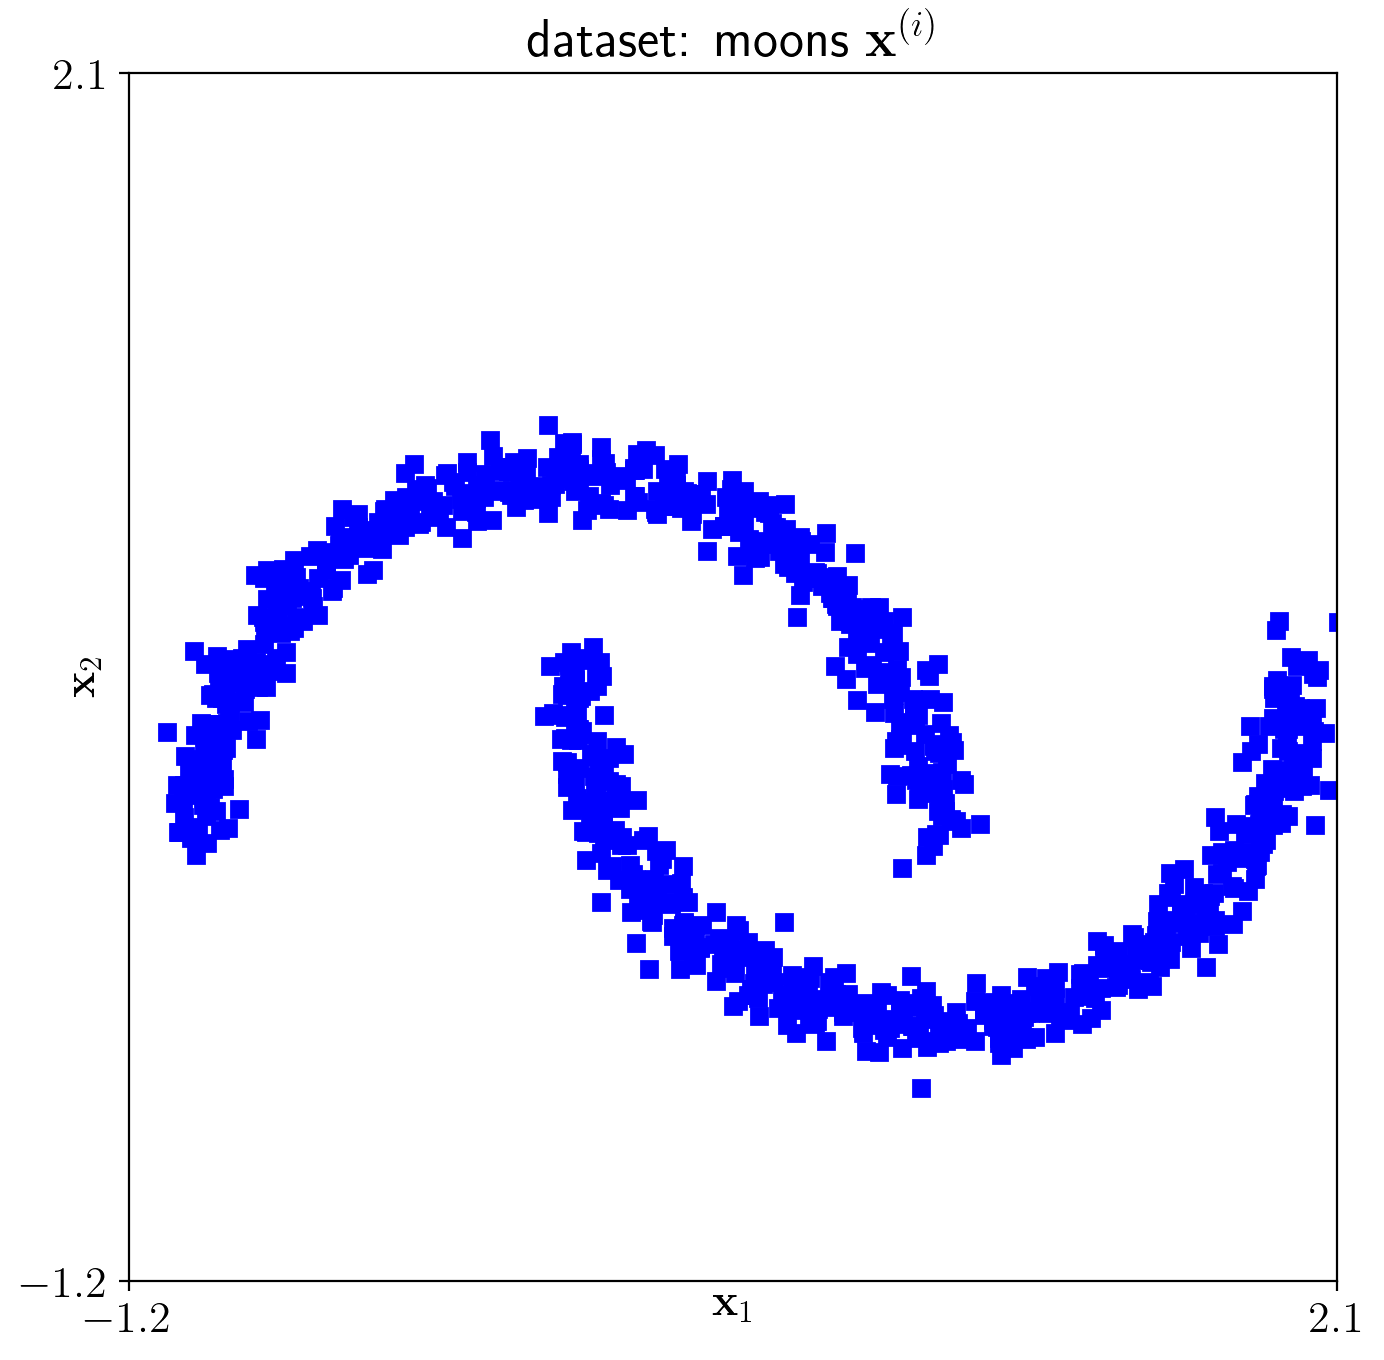

In [3]:
dataset = 'moons'
# dataset = 'uniform'

if dataset == 'moons':
    # grid of the spatial domain (for plotting)
    domain = (-1.2, 2.1, -1.2, 2.1)

    def get_data(batch_size,noise=0.05):
        return torch.tensor(datasets.make_moons(n_samples=batch_size, noise=noise)[0], dtype=torch.float32)
elif dataset == 'uniform':
    domain = (-1.0, 3.0, -1.0, 3.0)
    def get_data(batch_size):
        return torch.rand((batch_size,2)) + 1.0
else:
    print("incorrect dataset")

# grid of the spatial domain (for plotting)
x1 = torch.linspace(domain[0],domain[1], 100)
x2 = torch.linspace(domain[2],domain[3], 100)
xg = torch.meshgrid(x1, x2)
xx = torch.cat((xg[0].reshape(-1, 1), xg[1].reshape(-1, 1)), 1)

from plotting import *

xs = get_data(1000)
plot_x(xs,domain)
plt.title("dataset: %s $\mathbf{x}^{(i)}$" % (dataset))

## Choose the Network Architecture

Here, we penalize the transport costs using the square of the $L_2$ norm.
Our flow is parameterized as the gradient of a scalar function $\Phi$ also called the value function
or the potential in the optimal transport literature.
From the optimal control theory it follows that the optimal velocity is the gradient of $\Phi$.
The value function satisfies a Hamilton Jacobi Bellman (HJB) equation, whose violation we penalize along the
characteristics given by the flow.

The network for $\Phi$ consists of only two layers (one opening layer and a ResNet layer).

In [15]:
from OTFlow import *
from Phi import *
nTh = 2# number of layers
width = 32 # width of network
alph = [1.0,10.0,5.0] # alph[0]-> weight for transport costs, alph[1] and alph[2]-> HJB penalties
net = Phi(nTh=nTh, m=width, d=2, alph=alph).to(device)
prior = distributions.MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))
nt = 2                 # number of rk4 steps to solve neural ODE

flow = OTFlow(net, nt, alph, prior, T=1.0)


## Train the Generator

Here, we use ADAM, a stochastic approximation scheme that operates on minibatches.

------device=cpu, nTh=2, width=32, batch_size=256, num_steps=10000------
   step          J        J_L       J_ML      J_HJB    
001000   1.9012e+01  3.4928e-01  1.7703e+00  1.9194e-01  
002000   1.0281e+01  3.3760e-01  9.2590e-01  1.3693e-01  
003000   7.1402e+00  3.7938e-01  6.0194e-01  1.4829e-01  
004000   6.1770e+00  3.8473e-01  5.0647e-01  1.4552e-01  
005000   5.8587e+00  3.8315e-01  4.7548e-01  1.4416e-01  
006000   5.6003e+00  3.8072e-01  4.5091e-01  1.4209e-01  
007000   5.4134e+00  3.7881e-01  4.3123e-01  1.4446e-01  
008000   5.3296e+00  3.7986e-01  4.1882e-01  1.5232e-01  
009000   5.1584e+00  3.7845e-01  4.0046e-01  1.5505e-01  
010000   4.9547e+00  3.8001e-01  3.7598e-01  1.6299e-01  


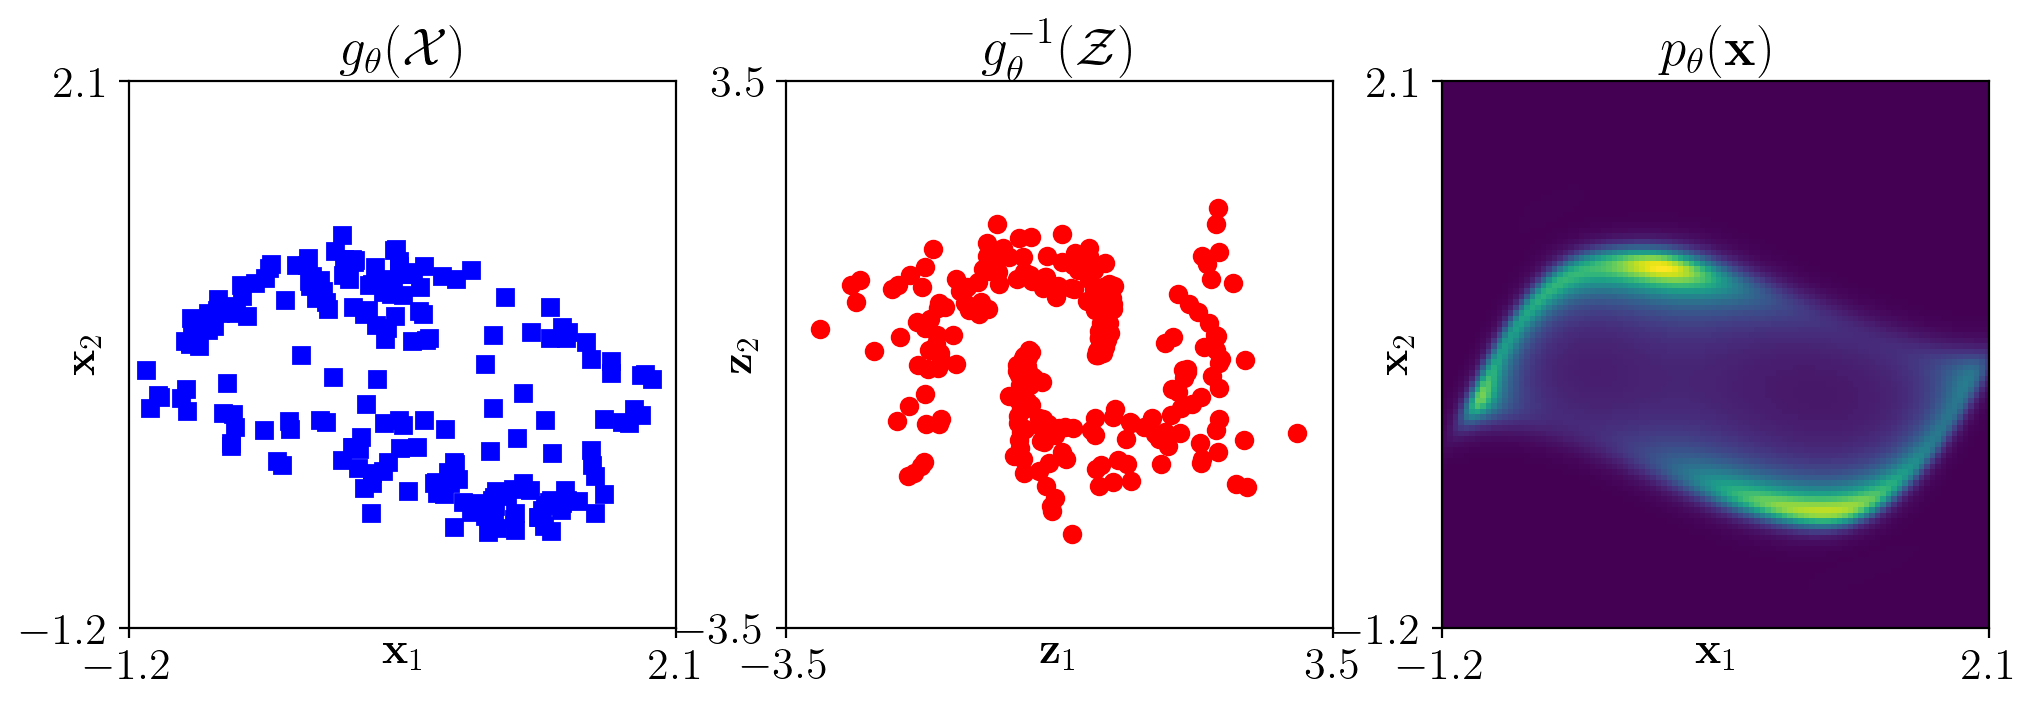

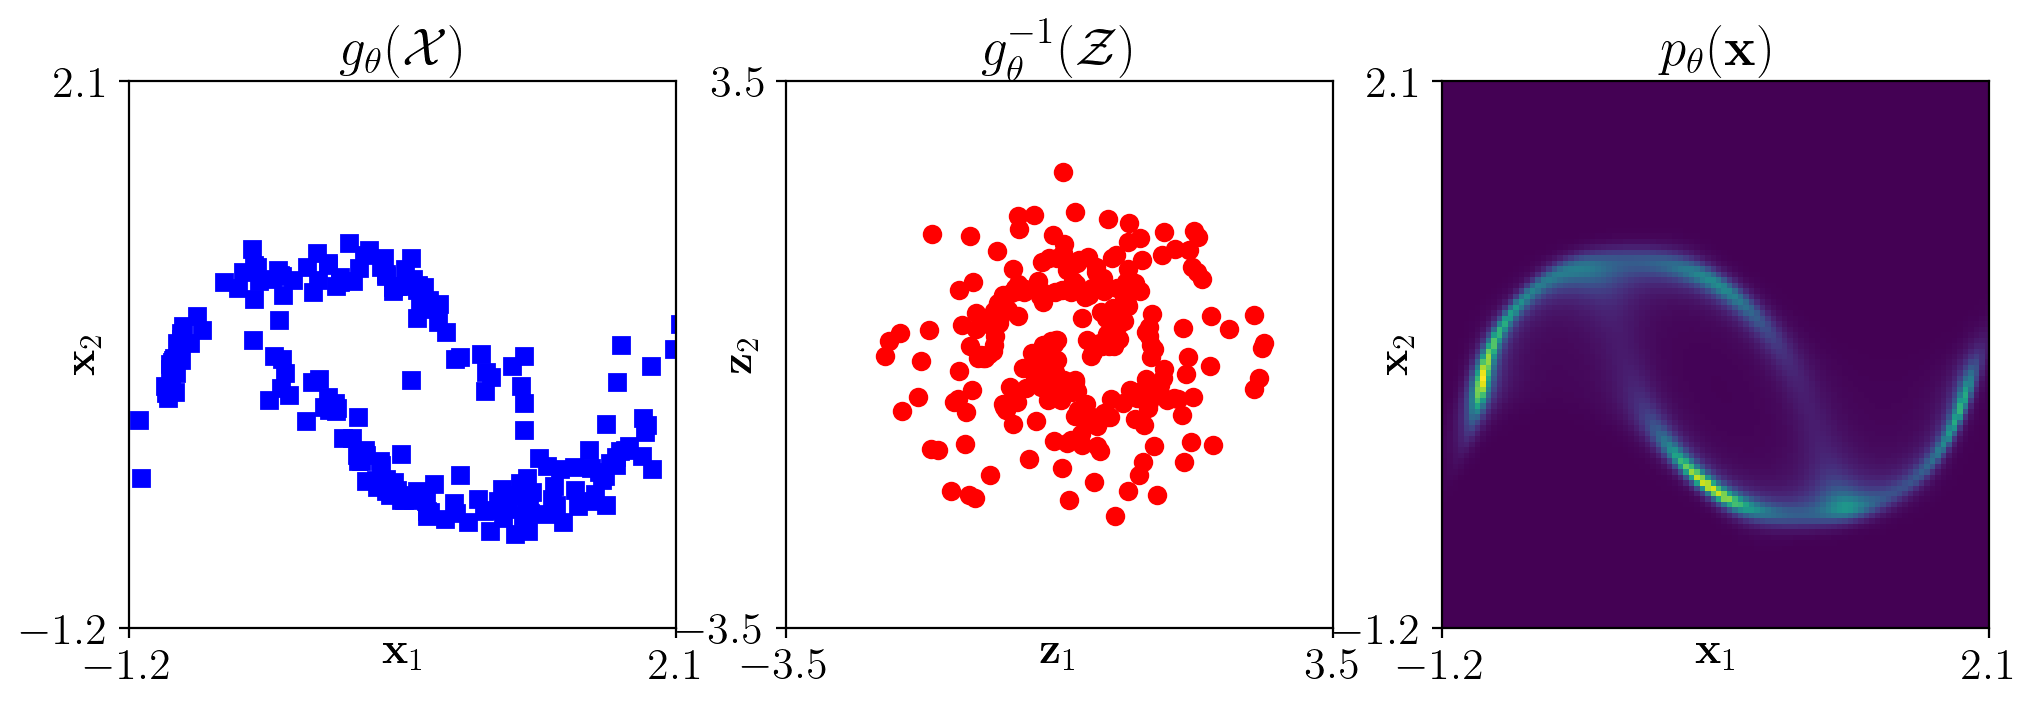

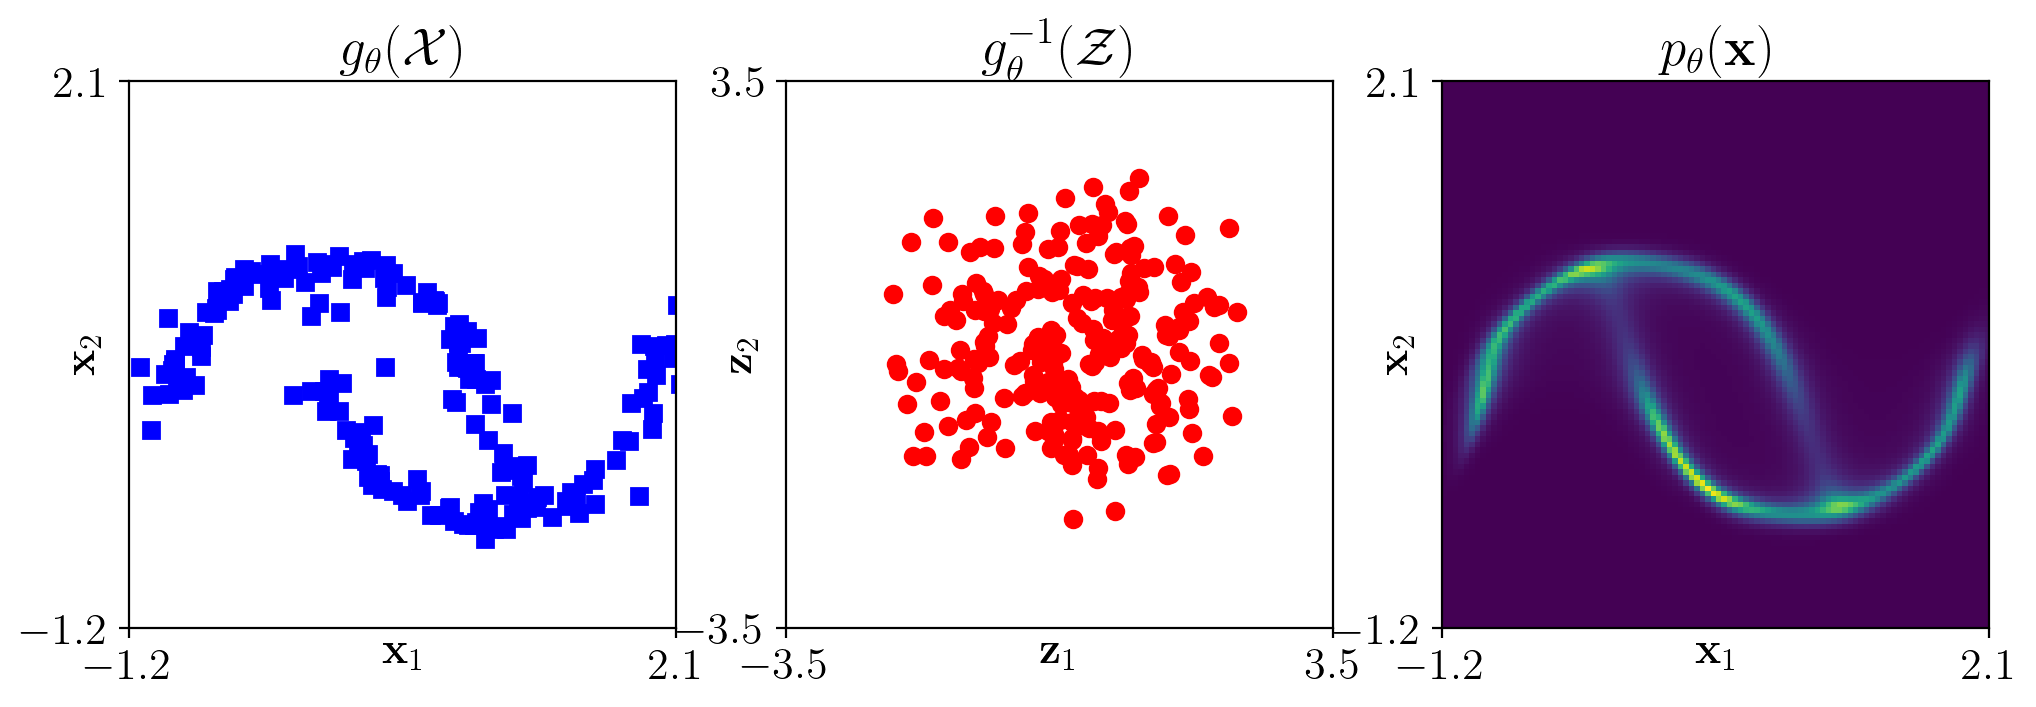

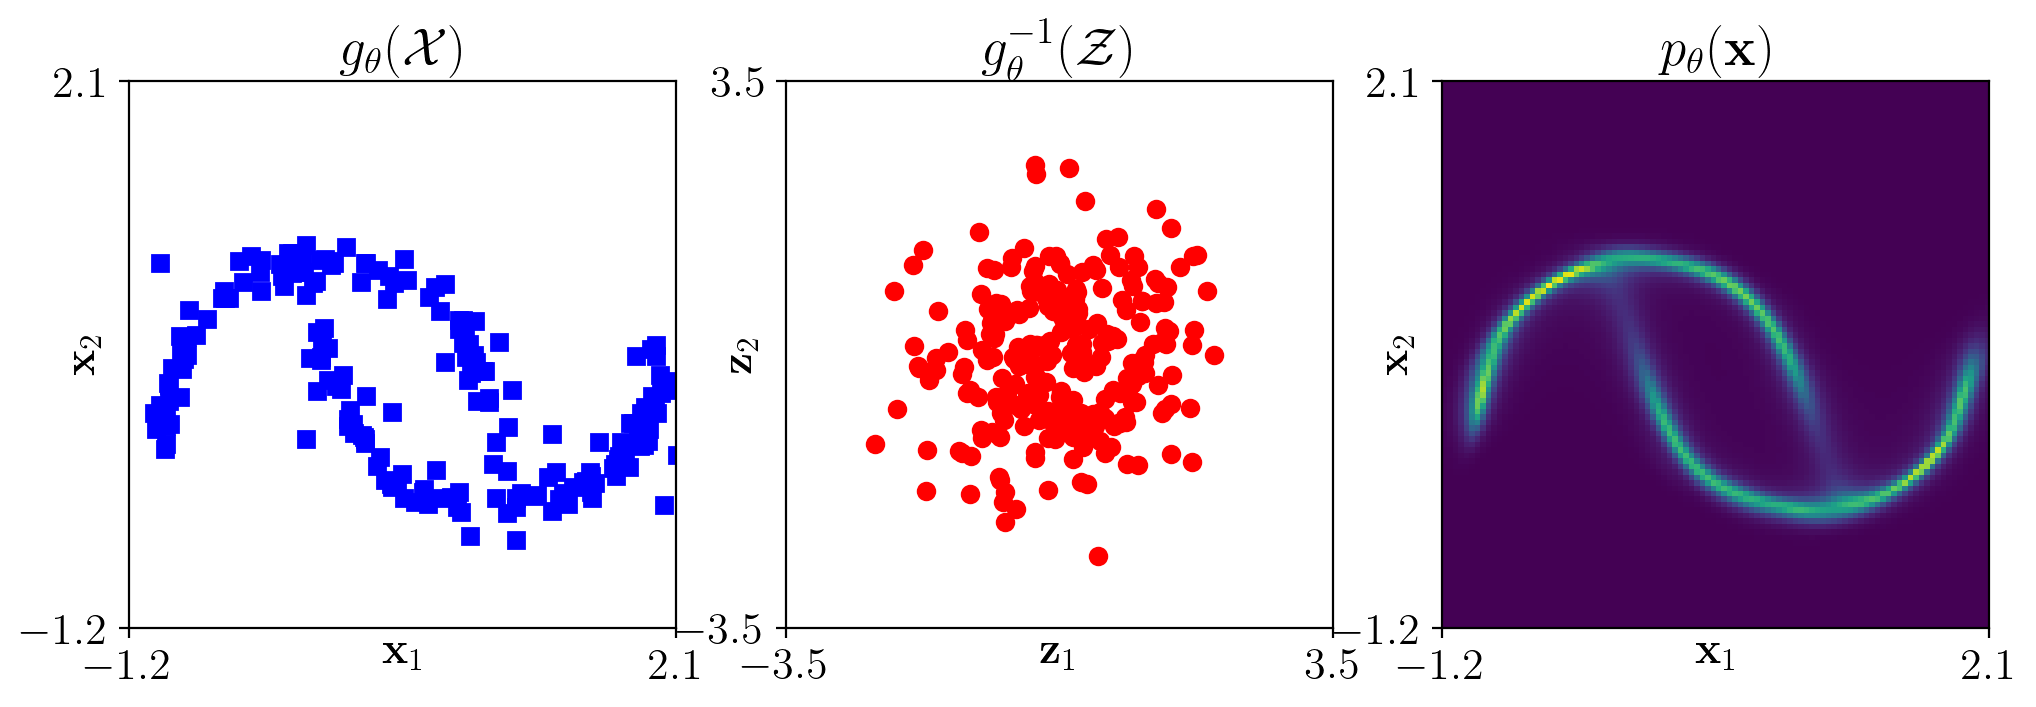

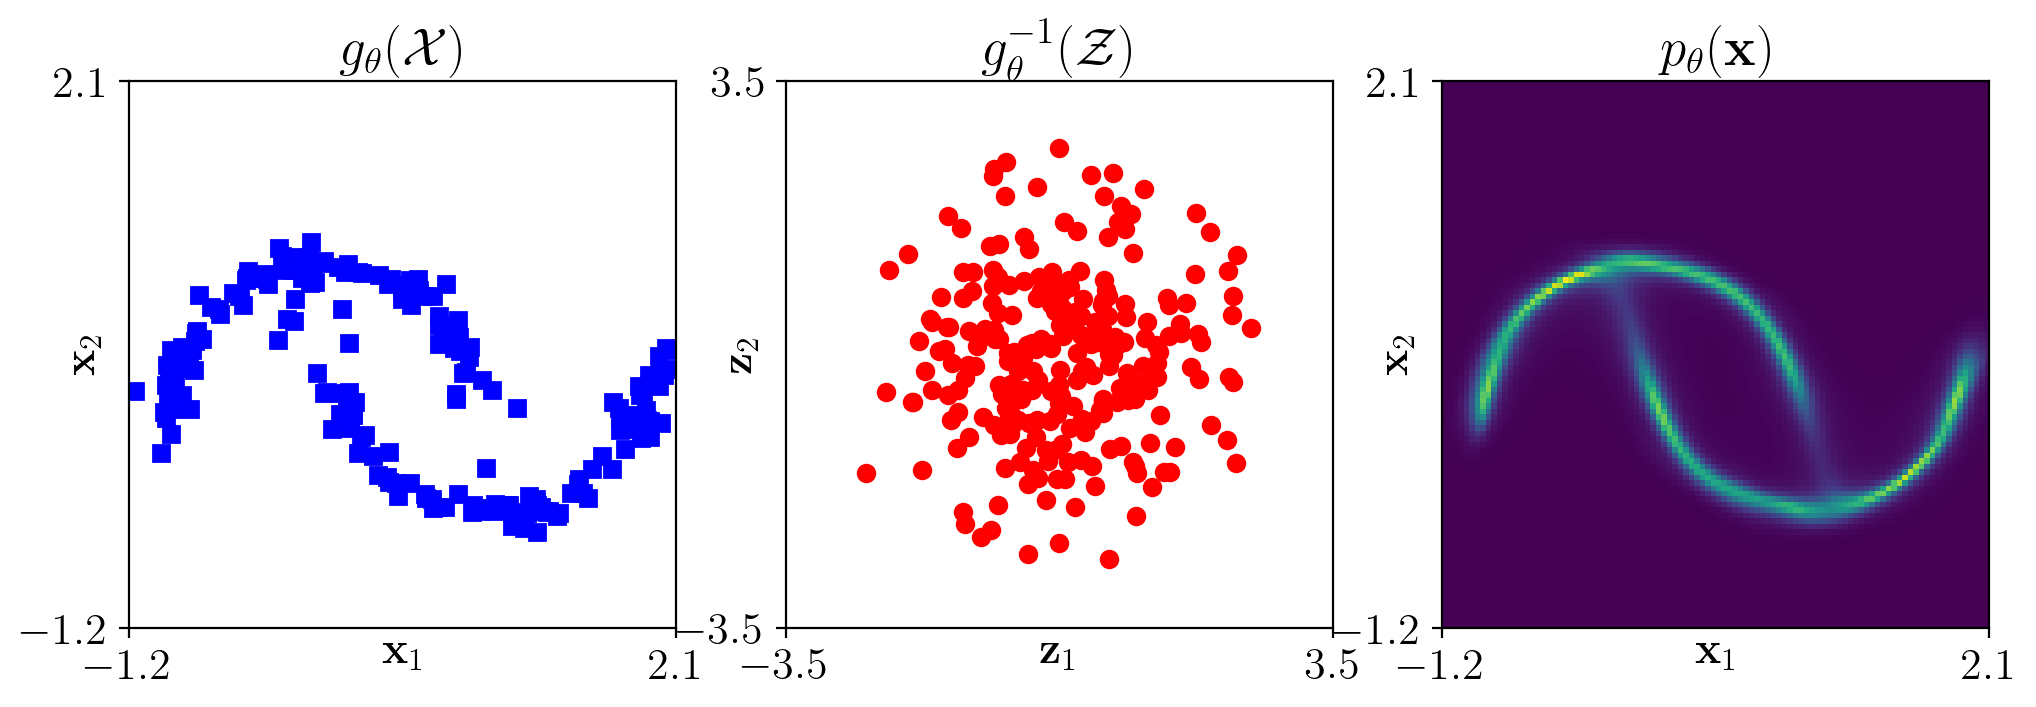

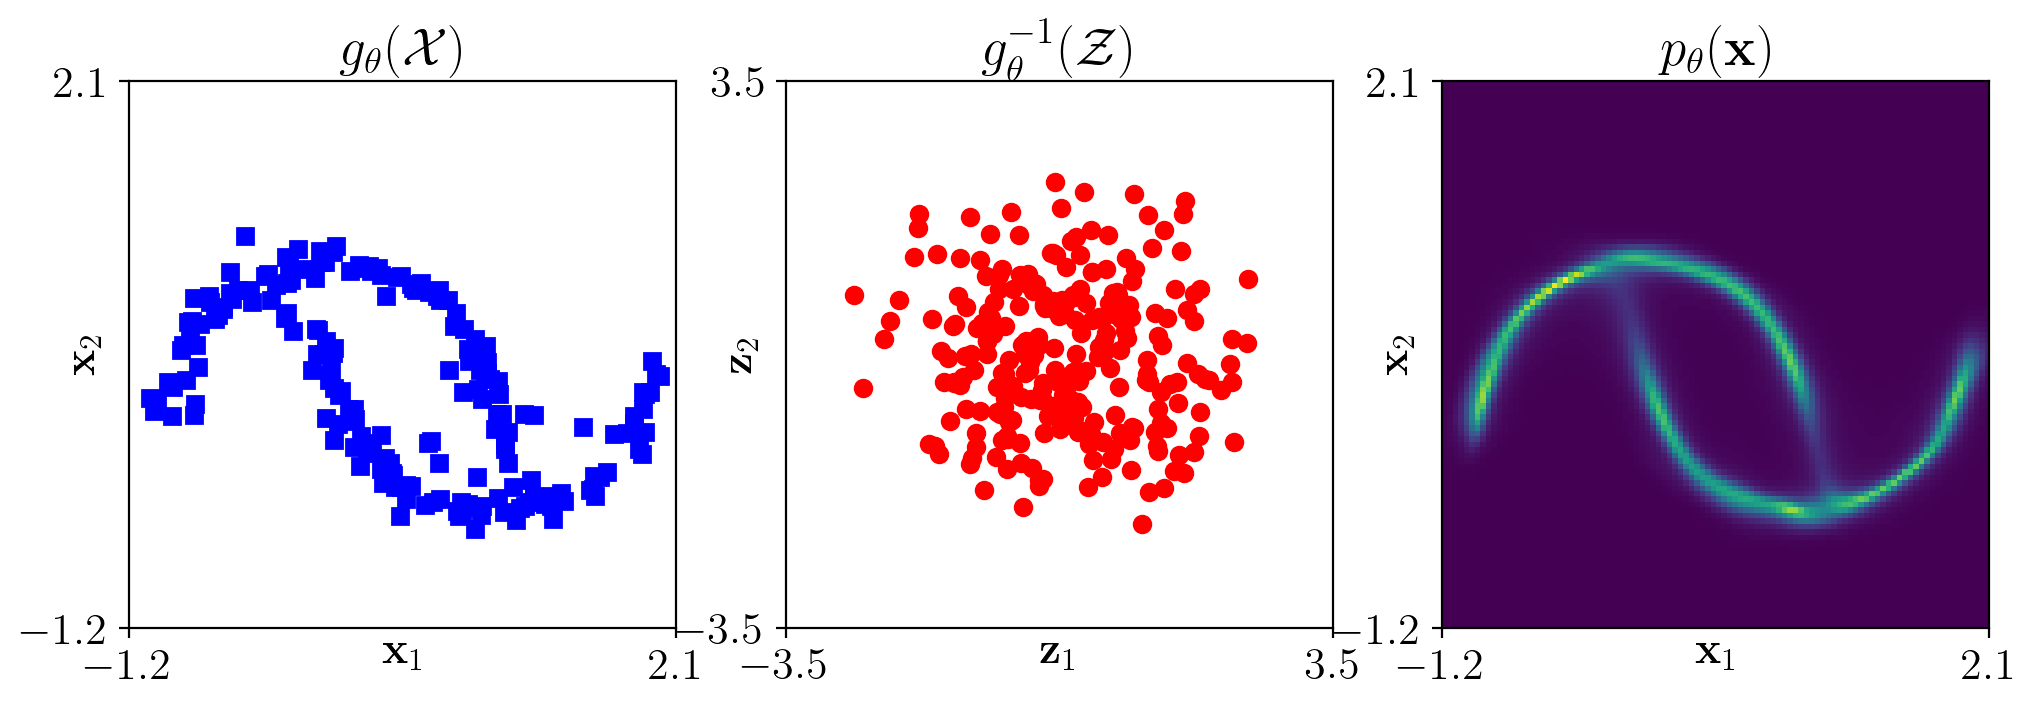

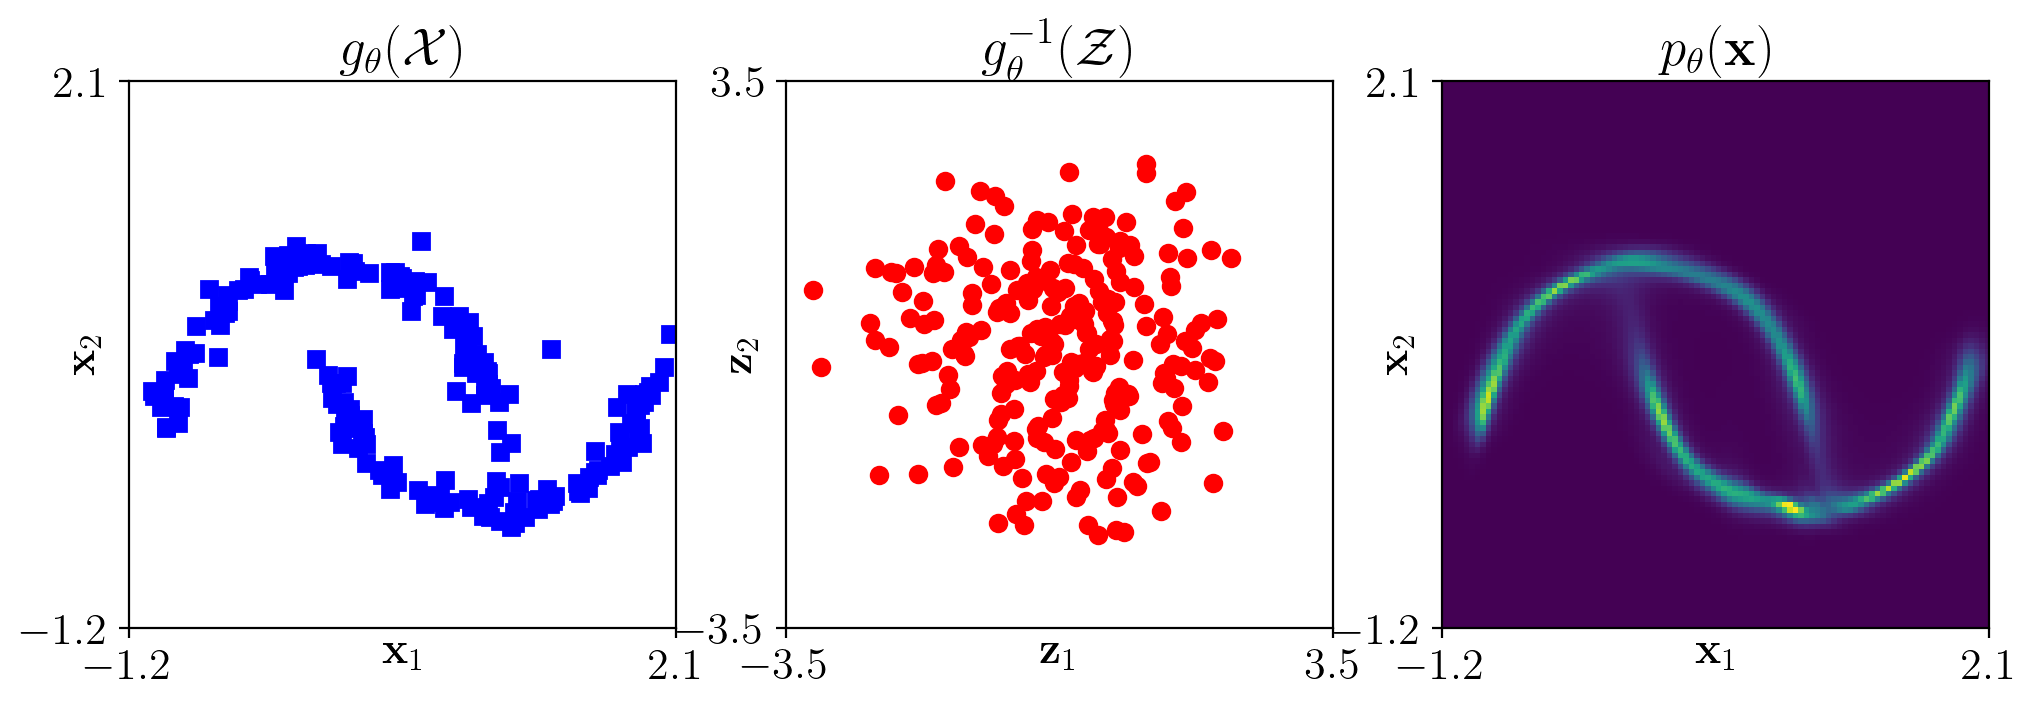

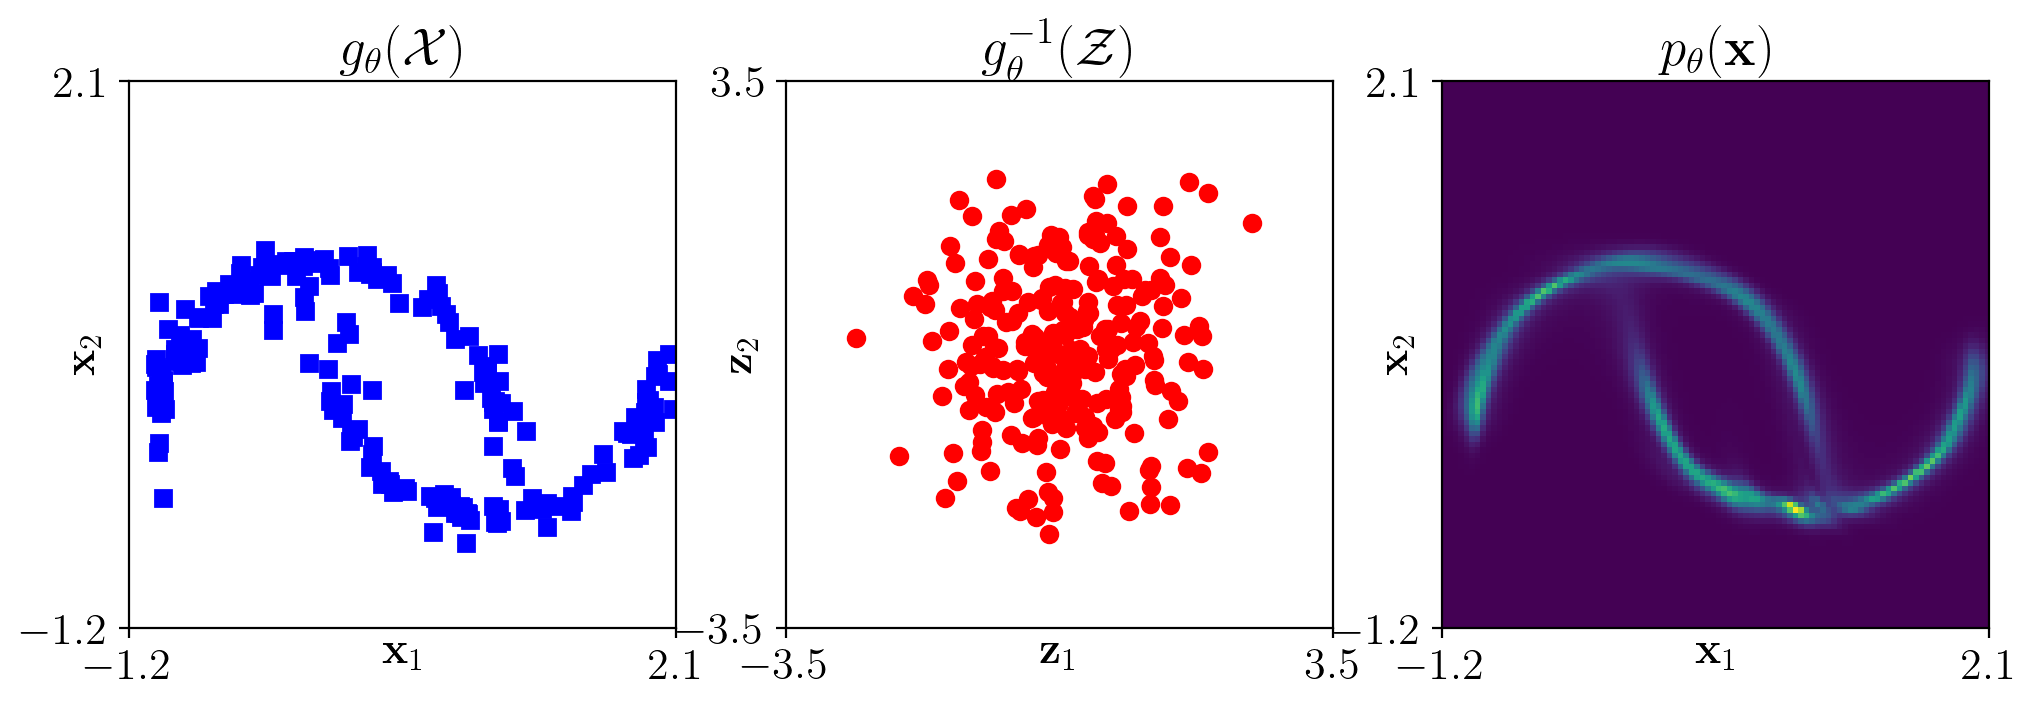

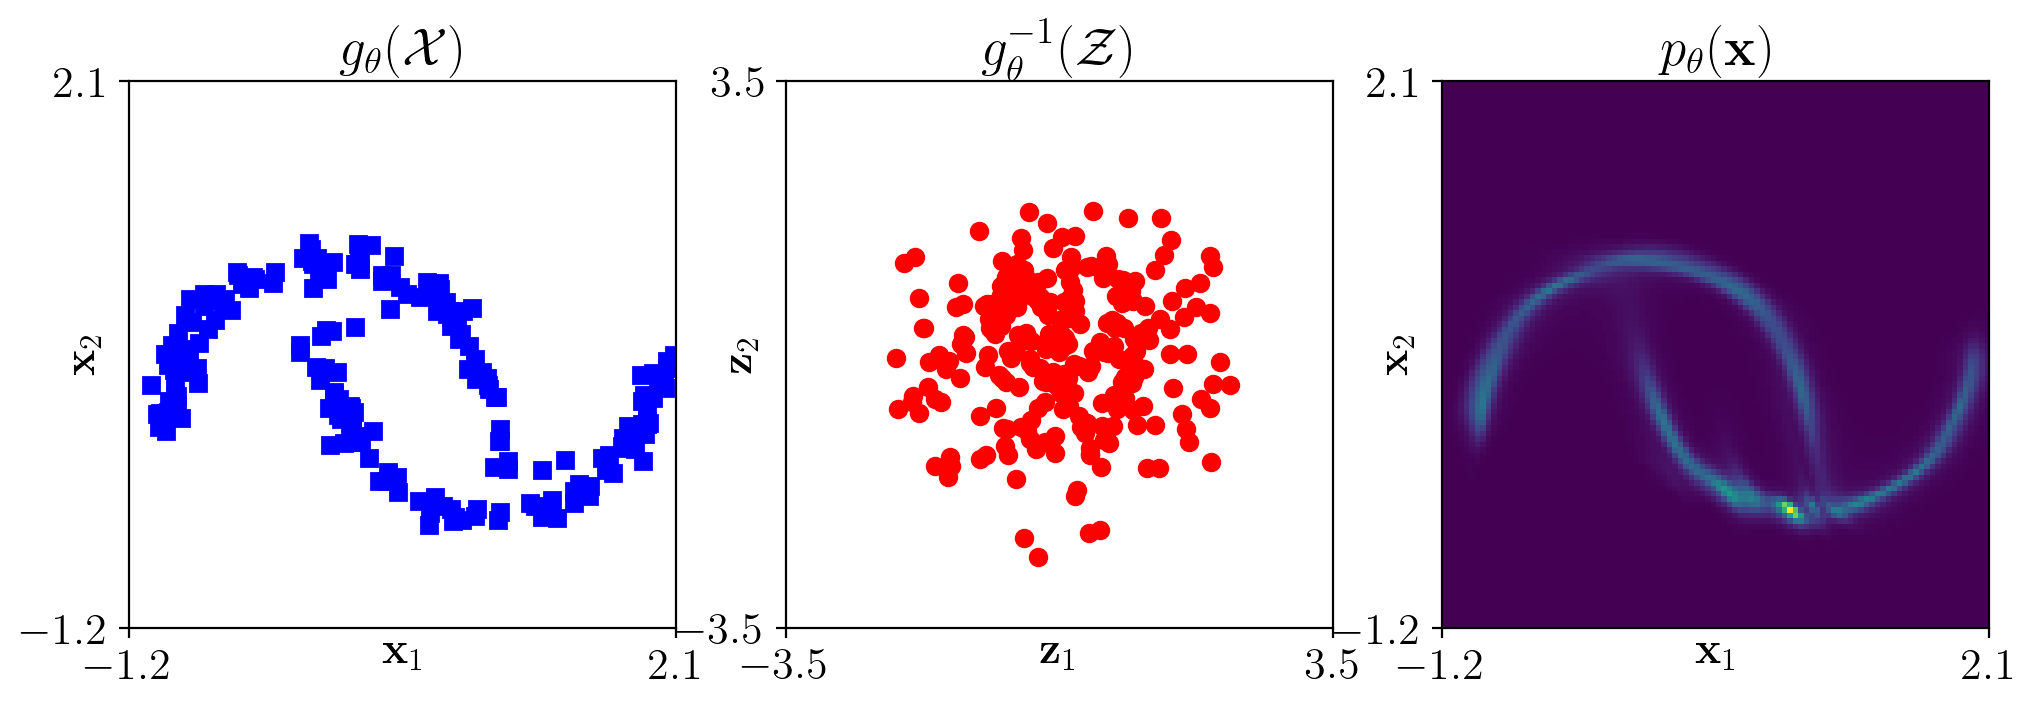

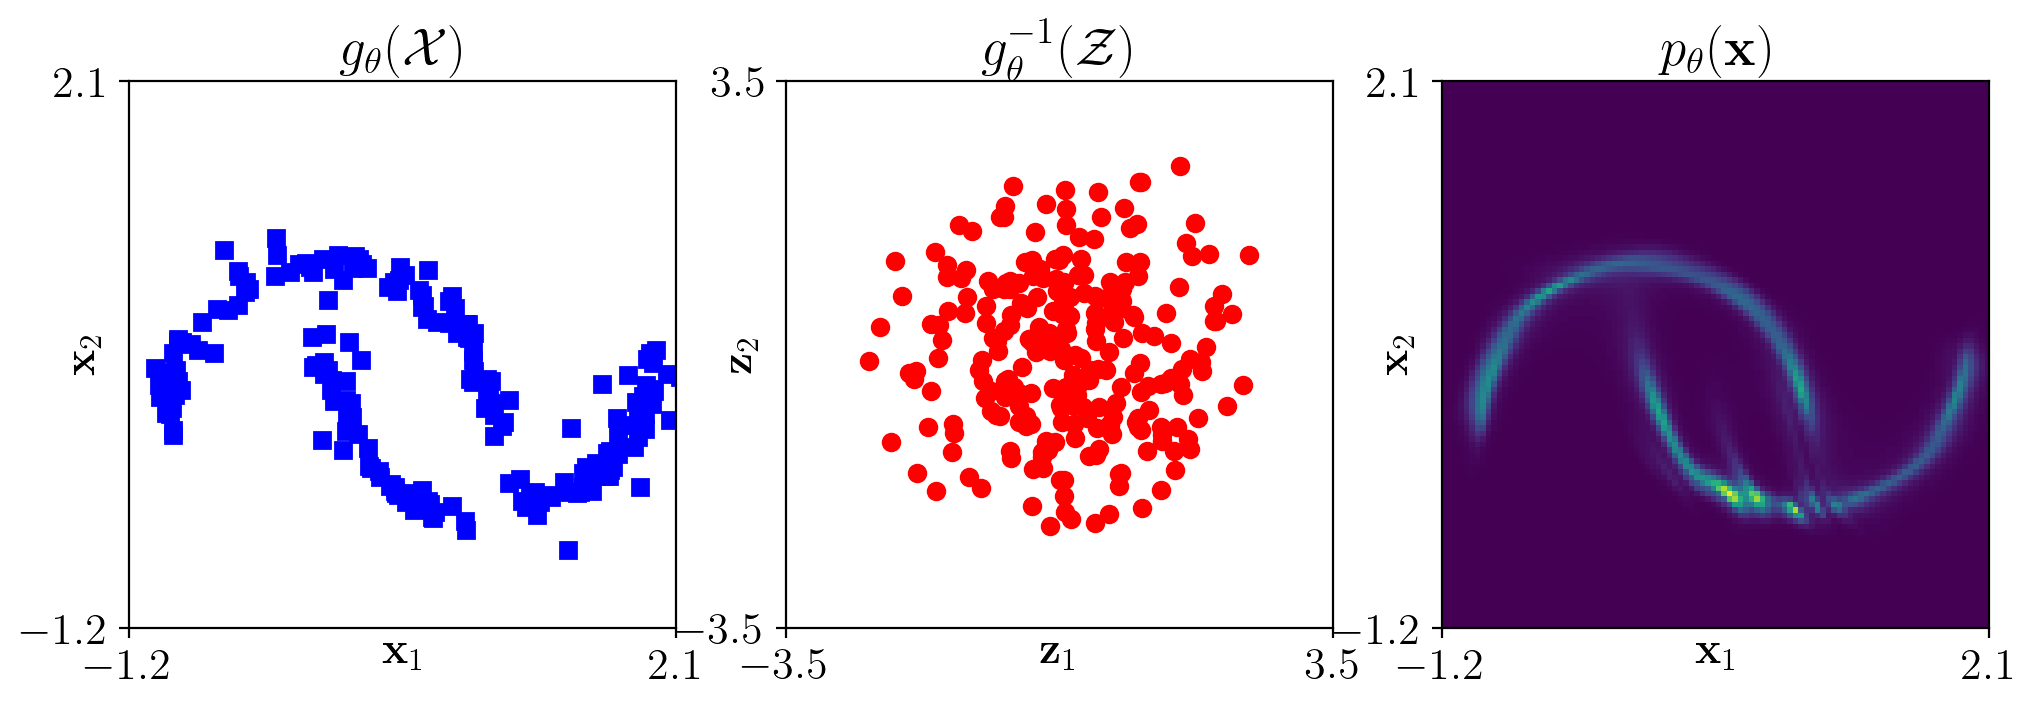

In [5]:
batch_size = 256
num_steps = 5000      # number of training steps
out_file=None          # base filename saving trained model
plot_interval = 500    # interval for visualizing intermediate results


optim = torch.optim.Adam(net.parameters(), lr=1e-2) # lr=0.04 good
his = np.zeros((0,4))

print((3*"--" + "device=%s, nTh=%d, width=%d, batch_size=%d, num_steps=%d" + 3*"--") % (device, nTh, width, batch_size, num_steps, ))

if out_file is not None:
    import os
    out_dir, fname = os.path.split(out_file)
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    print((3*"--" + "out_file: %s" + 3*"--") % (out_file))

print((5*"%7s    ") % ("step","J", "J_L", "J_ML","J_HJB"))
train_J = 0.0
train_L = 0.0
train_JML = 0.0
num_step = 0
train_HJB = 0.0

for step in range(num_steps):

    x = get_data(batch_size).to(device)
    optim.zero_grad()
    log_prob,L,P = flow.log_prob(x)
    loss = (- alph[1]*log_prob + alph[0]*L + alph[2]*P).mean()
    loss.backward()
    optim.step()

    train_J += loss.item()
    train_L += L.mean().item()
    train_JML += - log_prob.mean().item()
    train_HJB += P.mean().item()
    num_step += 1

    if (step + 1) % plot_interval == 0:
        train_J /= num_step
        train_JML /= num_step
        train_L /= num_step
        train_HJB /= num_step


        print(("%06d   " + 4*"%1.4e  ") %
              (step + 1, train_J, train_L, train_JML, train_HJB))
        his = np.vstack([his, [train_J, train_L, train_JML, train_HJB]])
        train_J = 0.0
        train_L = 0.0
        train_JML = 0.0
        num_step = 0
        train_HJB = 0.0

        with torch.no_grad():
            zs = flow.ginv(x)[0].detach().cpu()
            xs = flow.sample(200).detach().cpu()
            log_px = flow.log_prob(xx)[0].detach()

            plt.Figure()
            plt.subplot(1,3,1)
            plot_x(xs,domain)
            plt.title("$g_{\\theta}(\mathcal{X})$")

            plt.subplot(1,3,2)
            plot_z(zs)
            plt.title("$g^{-1}_{\\theta}(\mathcal{Z})$")

            plt.subplot(1,3,3)
            plot_px(log_px.reshape(len(x1), len(x2)),domain)
            plt.title("$p_{\\theta}(\mathbf{x})$")
            plt.margins(0, 0)
        if out_file is not None:
            plt.savefig("%s-step-%d.png" % (out_file,step+1), bbox_inches='tight', pad_inches=0)
        plt.show()

if out_file is not None:
    torch.save(net.state_dict(), ("%s.pt") % (out_file))
    from scipy.io import savemat
    savemat(("%s.mat") % (out_file), {"his":his})

## Visualize the Final Result

Compare this to Figure 6 in [https://arxiv.org/abs/2103.05180](https://arxiv.org/abs/2103.05180)


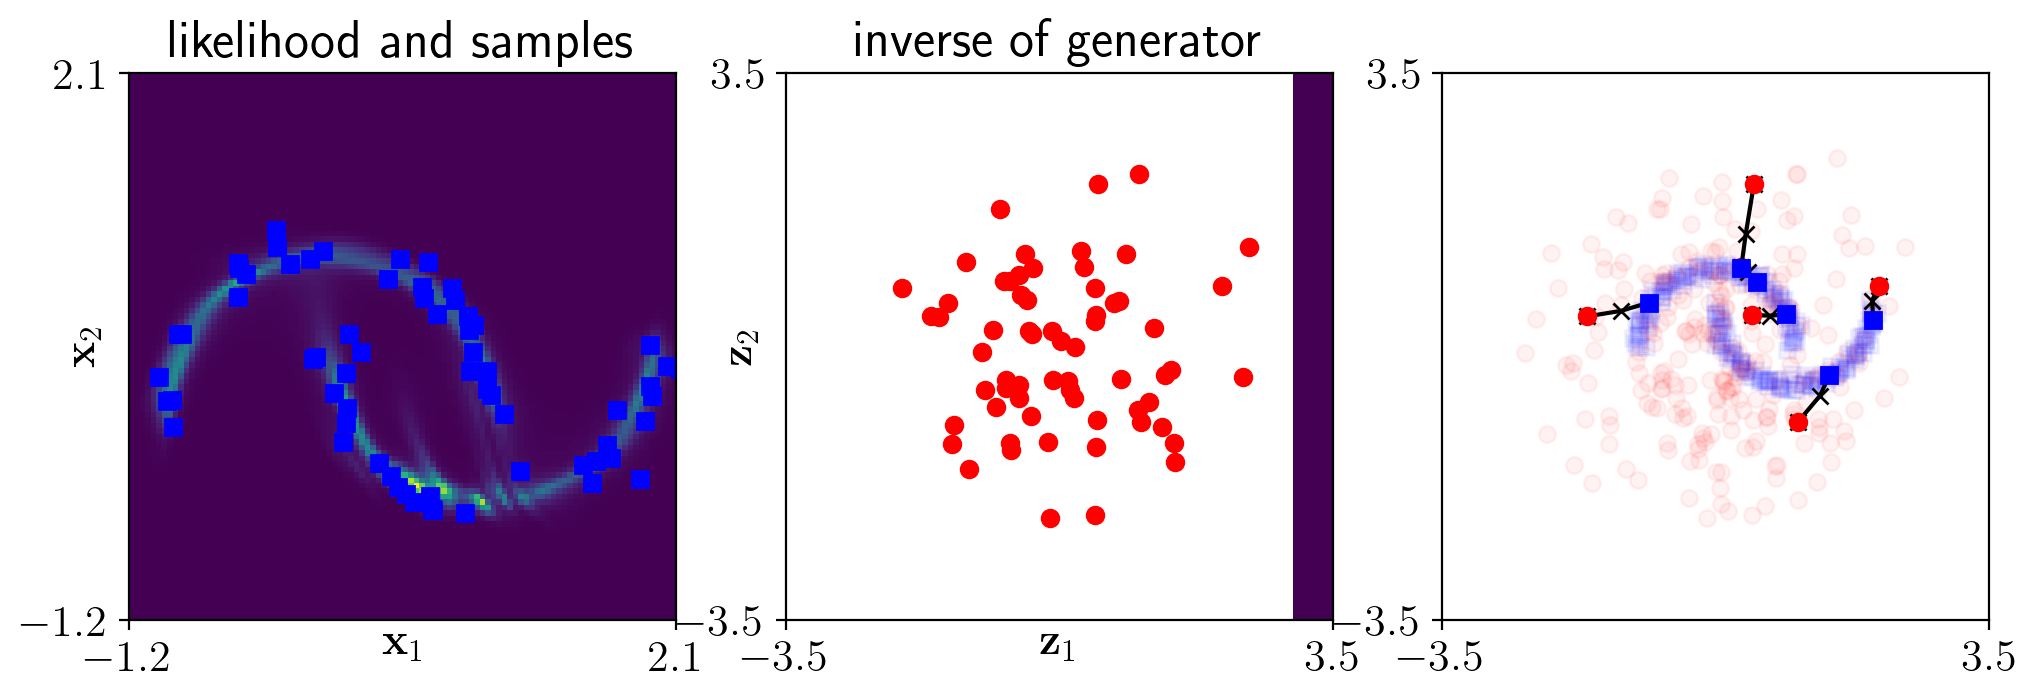

Text(0.5, 1.0, 'hidden layers')

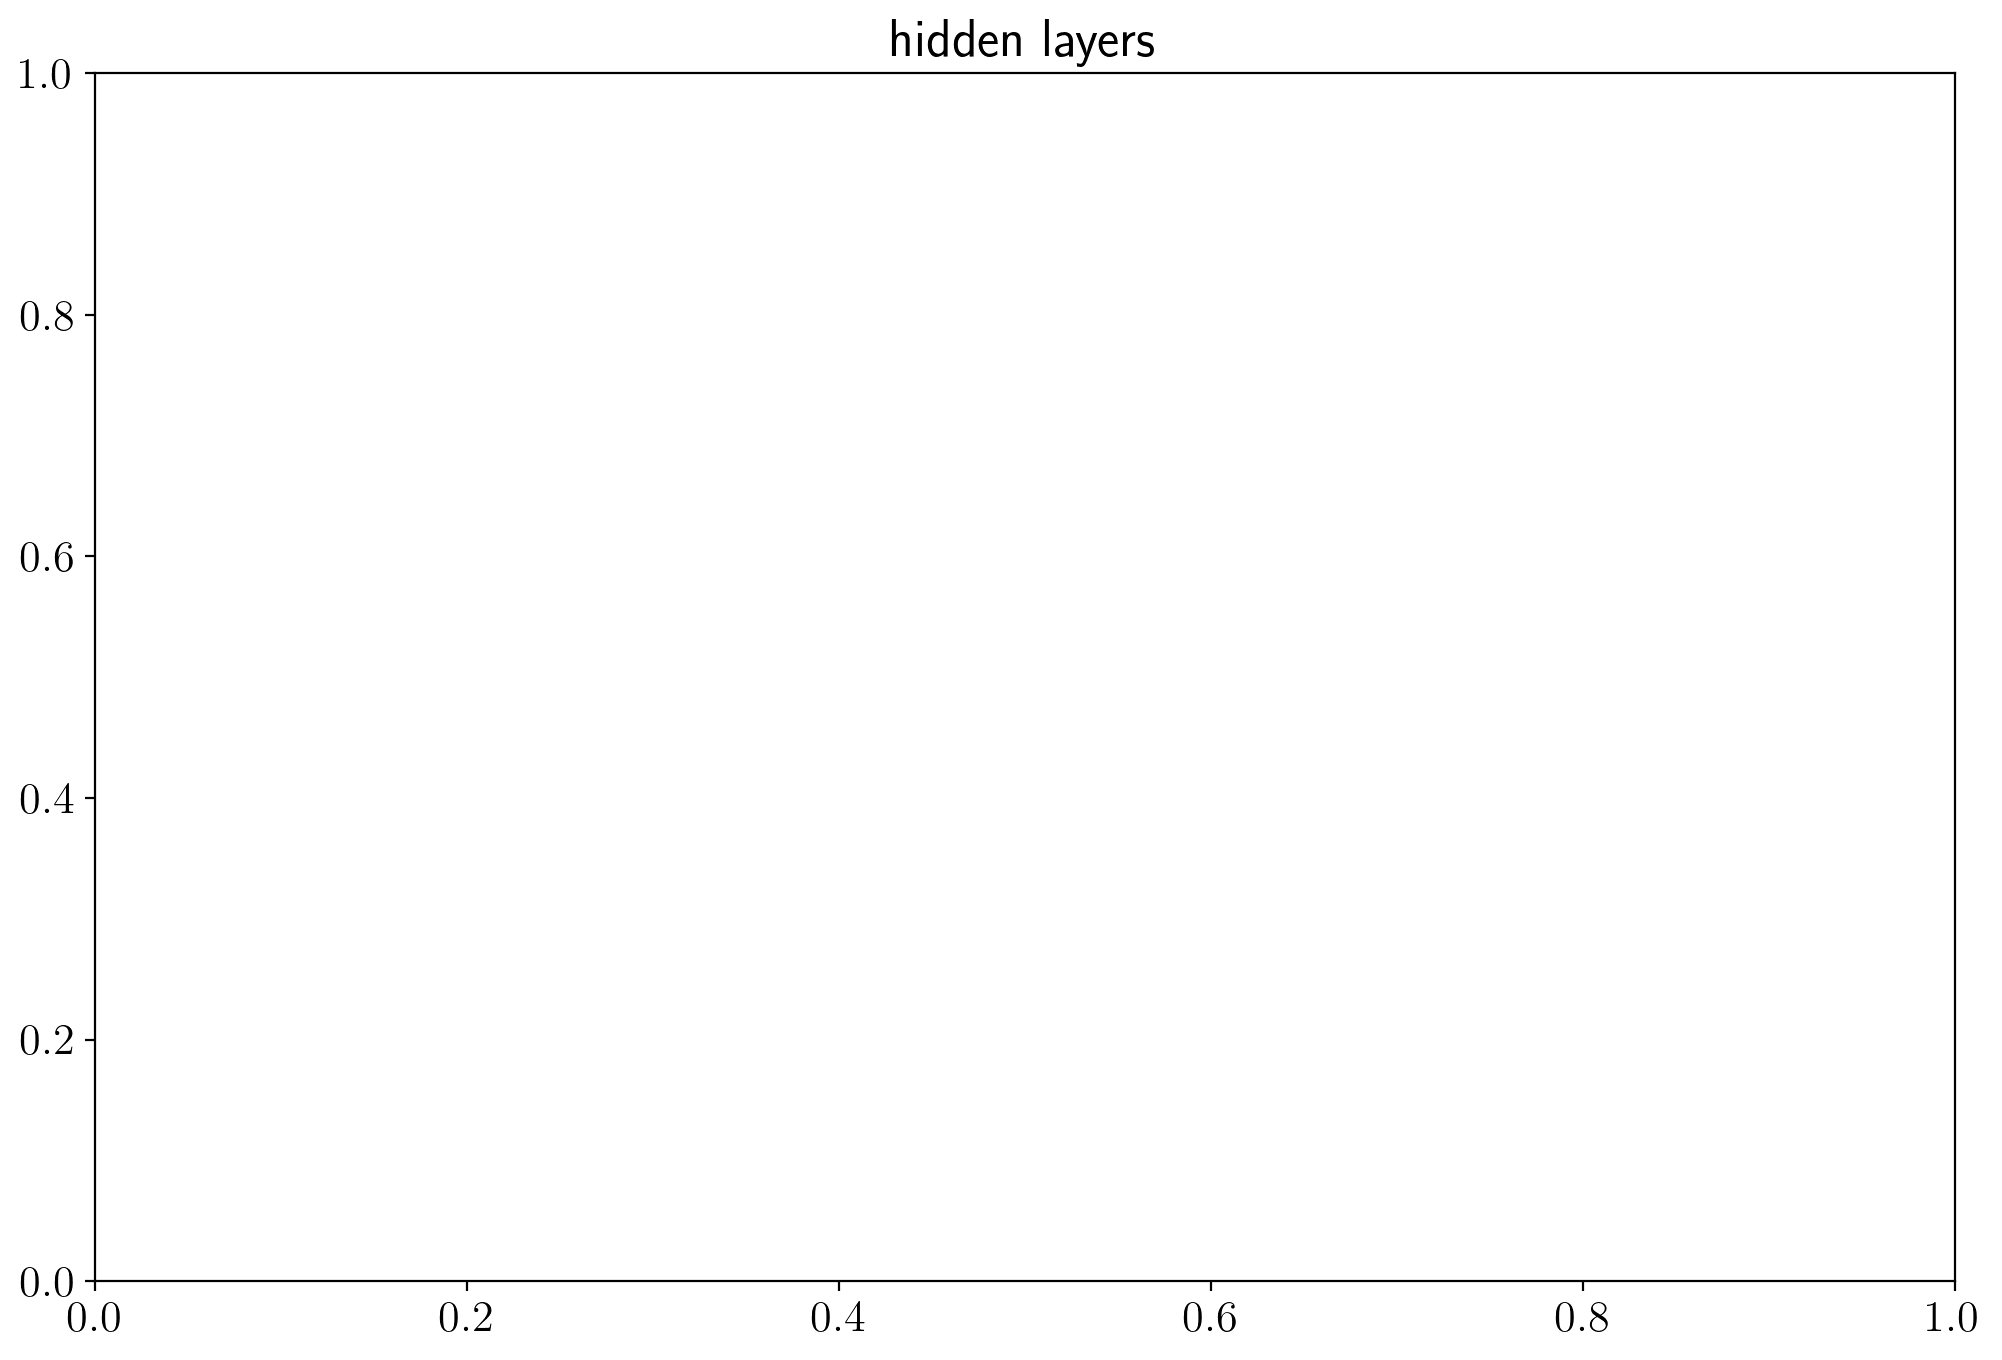

In [14]:
plt.Figure()
plt.subplot(1,3,1)
plot_px(log_px.reshape(len(x1), len(x2)),domain)
plot_x(xs[:64, :],domain)
plt.title("likelihood and samples")

xx = get_data(20000)
zz = flow.ginv(xx)[0].detach().numpy()

plt.subplot(1,3,2)
plot_pz(zz)
plot_z(zs[:64,:])
plt.title("inverse of generator")

zall = flow.ginv(x,storeAll=True)[1]
zall = torch.cat(zall,1)

plt.subplot(1,3,3)
plt.plot(x[:, 0], x[:, 1], "bs",alpha=0.05)
plt.plot(zs[:, 0], zs[:, 1], "or",alpha=0.05)

for k in range(6):
    zk = zall[k,:].reshape(-1,2)
    plt.plot(zk[:, 0], zk[:, 1], "-xk")
    plt.plot(zk[0, 0], zk[0, 1], "bs")
    plt.plot(zk[-1, 0], zk[-1, 1], "or")

plt.axis("square")
plt.axis((-3.5, 3.5, -3.5, 3.5))
plt.xticks((-3.5, 3.5))
plt.yticks((-3.5, 3.5))
plt.margins(0, 0)
plt.show()
plt.title("hidden layers")